# Cardiovascular Disease Risk Prediction Project


# 1. Introduction and Setup

*Project Goal:* To analyze a dataset containing patient information (objective, examination, subjective features) and build machine learning models to predict the presence or absence of cardiovascular disease (CVD).

*Dataset:* We are using a dataset commonly found on platforms like Kaggle, which includes demographic data, medical examination results (like blood pressure, cholesterol), and self-reported habits (smoking, alcohol).

*Approach:*
1.  **Load and Explore:** Understand the data structure, types, and basic statistics.
2.  **Clean and Preprocess:** Handle inconsistencies, outliers, and transform features (like age) for better usability.
3.  **Exploratory Data Analysis (EDA):** Visualize distributions and relationships between features and the target variable (CVD presence).
4.  **Feature Engineering:** Create potentially useful new features from existing ones (e.g., BMI, Blood Pressure Category).
5.  **Prepare for Modeling:** Select features, create preprocessing pipelines (scaling, encoding), and split the data.
6.  **Train and Validate:** Build several classification models (KNN, Random Forest, Logistic Regression) and evaluate them robustly using cross-validation.
7.  **Evaluate on Test Set:** Assess the final performance of the trained models on unseen data.
8.  **Interpret:** Analyze feature importances or coefficients to understand what drives the predictions.
9.  **Conclude and Save:** Choose the best model based on relevant metrics and save the complete pipeline for future use (like in a web application).

### 1.1 Import Libraries
Let's start by importing all the necessary Python libraries for data manipulation, visualization, preprocessing, modeling, and evaluation.

In [65]:
# Core Libraries for data handling and numerical operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings

# Preprocessing & Feature Engineering Tools from Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    ConfusionMatrixDisplay # For plotting confusion matrices nicely
)

# Feature Selection (Example tool)
from sklearn.feature_selection import SelectKBest, f_classif

# Model Persistence (Saving/Loading trained models)
import joblib

# --- Configure Settings ---
# Set a nice visual style for plots
sns.set(style="whitegrid")
# Ignore warnings (useful for cleaner presentation, but be cautious during development)
warnings.filterwarnings('ignore')
# Configure pandas to display all columns in DataFrames
pd.set_option('display.max_columns', None)

### 2. Data Loading and Initial Exploration

Now, we'll load the dataset. This dataset often uses a semicolon (`;`) as a separator. We'll then take a first look at its structure and contents.

In [66]:
print("--- 2. Data Loading & Initial Analysis ---")
# Define the expected filename - adjust if yours is different
DATA_FILE = 'cardio_train.csv' # Common name for this dataset

# --- Load the dataset ---
try:
    # Attempt to load using the defined filename and common separator
    df = pd.read_csv(DATA_FILE, sep=';')
    print(f"Dataset '{DATA_FILE}' loaded successfully.")
except FileNotFoundError:
    # Handle case where the file isn't found
    print(f"Error: Dataset file '{DATA_FILE}' not found in the current directory.")
    print("Please make sure the dataset file is available.")
    # Exit if the data can't be loaded, as the rest of the notebook depends on it
    exit()
except Exception as e:
    # Catch other potential loading errors
    print(f"An error occurred while loading the dataset: {e}")
    exit()

# --- Basic Exploration ---
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Information (Columns, Data Types, Non-Null Counts):")
df.info()

print("\nBasic Statistical Summary (Numerical Features - Raw):")
# Provides count, mean, std dev, min, max, and quartiles for numerical columns
print(df.describe())

# --- Define Target Variable ---
# The 'cardio' column indicates the presence (1) or absence (0) of CVD.
TARGET_COLUMN = 'cardio'

print(f"\nTarget Variable Distribution ('{TARGET_COLUMN}'):")
# Check the balance of the target variable (0 vs 1)
# normalize=True gives proportions instead of raw counts
print(df[TARGET_COLUMN].value_counts(normalize=True))
# Check raw counts as well
print(df[TARGET_COLUMN].value_counts())

# Observation: The dataset seems reasonably balanced (roughly 50/50 split for the target).

--- 2. Data Loading & Initial Analysis ---
Dataset 'cardio_train.csv' loaded successfully.

First 5 rows of the dataset:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Dataset Information (Columns, Data Types, Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       ------------

### 3. Data Cleaning and Preprocessing
Real-world data is rarely perfect. This section focuses on cleaning the data by handling potential issues like unnecessary columns, duplicates, and unrealistic values (especially in medical measurements like blood pressure). We also transform features like 'age' into a more interpretable format.

#### 3.1. Handling ID, Missing Values, and Duplicates

In [67]:
print("\n--- 3.1 Handling ID, Missing Values, and Duplicates ---")

# --- Drop the ID column ---
# The 'id' column is just an identifier and doesn't provide predictive value for the model.
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)
    print("Dropped the 'id' column as it's not needed for modeling.")
else:
    print("'id' column not found in the dataset.")

# --- Missing Values Check ---
print("\nChecking for missing values in each column:")
missing_values = df.isnull().sum()
print(missing_values)
if missing_values.sum() == 0:
    print("No missing values found in the dataset. Great!")
else:
    print("Missing values detected. Further handling (e.g., imputation) would be needed.")
    # Note: This specific dataset typically doesn't have NaNs, but this check is crucial practice.

# --- Duplicate Values Check and Removal ---
# Check for and remove any completely duplicate rows.
initial_row_count = len(df)
duplicates_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows found (before removal): {duplicates_count}")

if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Removed {duplicates_count} duplicate rows.")
    print(f"Dataset shape after duplicate removal: {df.shape}")
else:
    print("No duplicate rows to remove.")



--- 3.1 Handling ID, Missing Values, and Duplicates ---
Dropped the 'id' column as it's not needed for modeling.

Checking for missing values in each column:
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64
No missing values found in the dataset. Great!

Number of duplicate rows found (before removal): 24
Removed 24 duplicate rows.
Dataset shape after duplicate removal: (69976, 12)


#### 3.2. Feature Transformation (Age)

In [68]:
print("\n--- 3.2 Feature Transformation (Age) ---")
# Convert age from days to years for better interpretability
# Using 365.25 accounts roughly for leap years
df['age_years'] = (df['age'] / 365.25).round().astype(int)
# Drop the original 'age' column as we now have 'age_years'
df.drop('age', axis=1, inplace=True)
print("Converted 'age' feature from days to years ('age_years').")
print("First few values of 'age_years':\n", df['age_years'].head())


--- 3.2 Feature Transformation (Age) ---
Converted 'age' feature from days to years ('age_years').
First few values of 'age_years':
 0    50
1    55
2    52
3    48
4    48
Name: age_years, dtype: int64


#### 3.3. Outlier Detection and Handling

Outliers, especially measurement errors, can significantly impact model performance. Blood pressure (ap_hi, ap_lo), height, and weight are common areas where unrealistic values might appear in this dataset.



--- 3.3 Outlier Detection and Handling ---

Cleaning Blood Pressure (ap_hi, ap_lo) data...
Shape before BP cleaning: (69976, 12)
  - Found 1234 rows where diastolic > systolic pressure.
  - Found 228 rows with ap_hi outside [50, 250].
  - Found 1006 rows with ap_lo outside [30, 200].
Removed 1320 rows due to inconsistent or unrealistic blood pressure readings.
Shape after BP cleaning: (68656, 12)

Visualizing Height and Weight for outliers using Box Plots...


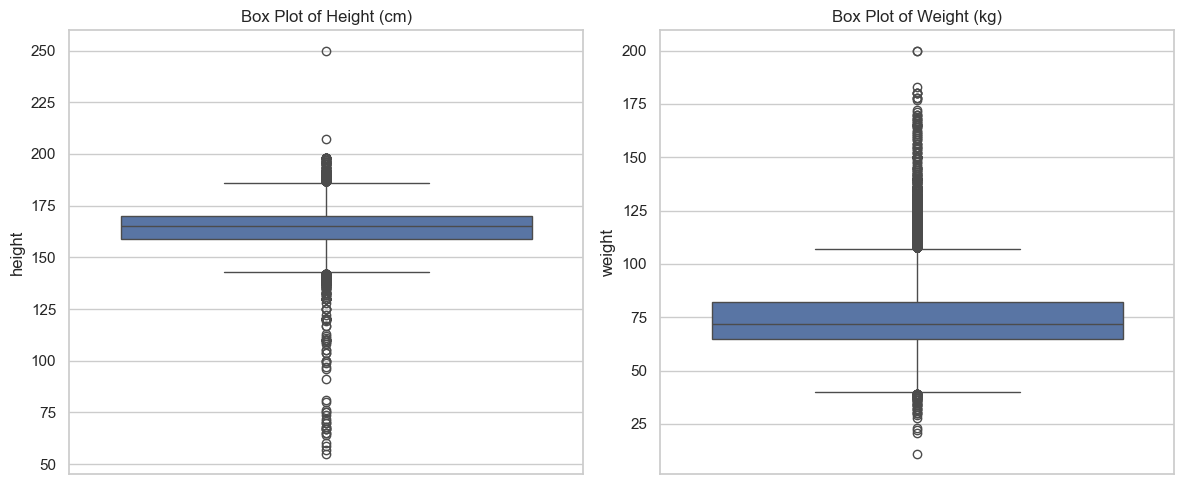


Filtering Height and Weight outliers based on percentiles...
Height bounds (1th-99th percentile): 147.00 cm - 184.00 cm
Weight bounds (1th-99th percentile): 48.00 kg - 117.00 kg
Removed 2407 rows based on height/weight percentile bounds.
Final shape after all cleaning: (66249, 12)


In [69]:
print("\n--- 3.3 Outlier Detection and Handling ---")

# --- Blood Pressure Cleaning (ap_hi, ap_lo) ---
# This is a critical step for this dataset due to known data quality issues.
print("\nCleaning Blood Pressure (ap_hi, ap_lo) data...")
print(f"Shape before BP cleaning: {df.shape}")

# Define plausible physiological ranges for blood pressure.
# These thresholds are based on common sense and typical errors found in this dataset.
# Systolic (ap_hi) usually ranges from ~50 to ~250 in extreme cases.
AP_HI_LOWER, AP_HI_UPPER = 50, 250
# Diastolic (ap_lo) usually ranges from ~30 to ~200.
AP_LO_LOWER, AP_LO_UPPER = 30, 200

# Identify problematic rows based on several conditions:
# 1. Diastolic pressure should not be higher than systolic pressure.
invalid_bp_logic = df['ap_lo'] > df['ap_hi']
print(f"  - Found {invalid_bp_logic.sum()} rows where diastolic > systolic pressure.")

# 2. Systolic pressure outside the plausible range.
invalid_bp_hi_range = (df['ap_hi'] < AP_HI_LOWER) | (df['ap_hi'] > AP_HI_UPPER)
print(f"  - Found {invalid_bp_hi_range.sum()} rows with ap_hi outside [{AP_HI_LOWER}, {AP_HI_UPPER}].")

# 3. Diastolic pressure outside the plausible range.
invalid_bp_lo_range = (df['ap_lo'] < AP_LO_LOWER) | (df['ap_lo'] > AP_LO_UPPER)
print(f"  - Found {invalid_bp_lo_range.sum()} rows with ap_lo outside [{AP_LO_LOWER}, {AP_LO_UPPER}].")

# Combine all invalid conditions
invalid_bp_mask = invalid_bp_logic | invalid_bp_hi_range | invalid_bp_lo_range

# Remove rows that meet any of the invalid BP criteria
initial_rows_bp = df.shape[0]
df = df[~invalid_bp_mask] # Keep rows where the mask is False
removed_rows_bp = initial_rows_bp - df.shape[0]

if removed_rows_bp > 0:
    print(f"Removed {removed_rows_bp} rows due to inconsistent or unrealistic blood pressure readings.")
else:
    print("No rows removed based on blood pressure checks (data might already be clean or thresholds too wide).")
print(f"Shape after BP cleaning: {df.shape}")


# --- Height and Weight Outlier Handling ---
# Visualize potential outliers using box plots.
print("\nVisualizing Height and Weight for outliers using Box Plots...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['height'])
plt.title('Box Plot of Height (cm)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['weight'])
plt.title('Box Plot of Weight (kg)')
plt.tight_layout()
plt.show()

# Observation: Box plots might show extreme values for height and weight.
# We'll use quantile-based filtering to remove the most extreme, potentially erroneous values.
# Removing the bottom and top 1% (adjust percentile as needed) is a common approach.
print("\nFiltering Height and Weight outliers based on percentiles...")
H_LOW_PERCENTILE, H_HIGH_PERCENTILE = 0.01, 0.99
W_LOW_PERCENTILE, W_HIGH_PERCENTILE = 0.01, 0.99

h_low_bound = df['height'].quantile(H_LOW_PERCENTILE)
h_high_bound = df['height'].quantile(H_HIGH_PERCENTILE)
w_low_bound = df['weight'].quantile(W_LOW_PERCENTILE)
w_high_bound = df['weight'].quantile(W_HIGH_PERCENTILE)

print(f"Height bounds ({H_LOW_PERCENTILE*100:.0f}th-{H_HIGH_PERCENTILE*100:.0f}th percentile): {h_low_bound:.2f} cm - {h_high_bound:.2f} cm")
print(f"Weight bounds ({W_LOW_PERCENTILE*100:.0f}th-{W_HIGH_PERCENTILE*100:.0f}th percentile): {w_low_bound:.2f} kg - {w_high_bound:.2f} kg")

# Apply the filtering
initial_rows_hw = df.shape[0]
df = df[(df['height'] >= h_low_bound) & (df['height'] <= h_high_bound)]
df = df[(df['weight'] >= w_low_bound) & (df['weight'] <= w_high_bound)]
removed_rows_hw = initial_rows_hw - df.shape[0]

if removed_rows_hw > 0:
    print(f"Removed {removed_rows_hw} rows based on height/weight percentile bounds.")
else:
    print("No rows removed based on height/weight percentile checks.")
print(f"Final shape after all cleaning: {df.shape}")

#### 4. Exploratory Data Analysis (EDA)

EDA helps us understand the characteristics of our data and the relationships between variables. We'll visualize the distributions of continuous and categorical features, also examining how they relate to the target variable (cardiovascular disease).


--- 4.1 Continuous Features Analysis ---

Identified Continuous Columns: ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']

Summary statistics for continuous columns (after cleaning):
          age_years        height        weight         ap_hi         ap_lo
count  66249.000000  66249.000000  66249.000000  66249.000000  66249.000000
mean      53.305801    164.460128     73.804063    126.631647     81.293846
std        6.750706      7.310927     12.897362     16.541402      9.387189
min       30.000000    147.000000     48.000000     60.000000     30.000000
25%       48.000000    159.000000     65.000000    120.000000     80.000000
50%       54.000000    165.000000     72.000000    120.000000     80.000000
75%       58.000000    170.000000     81.000000    140.000000     90.000000
max       65.000000    184.000000    117.000000    240.000000    182.000000

Visualizing distributions of continuous features using Histograms...


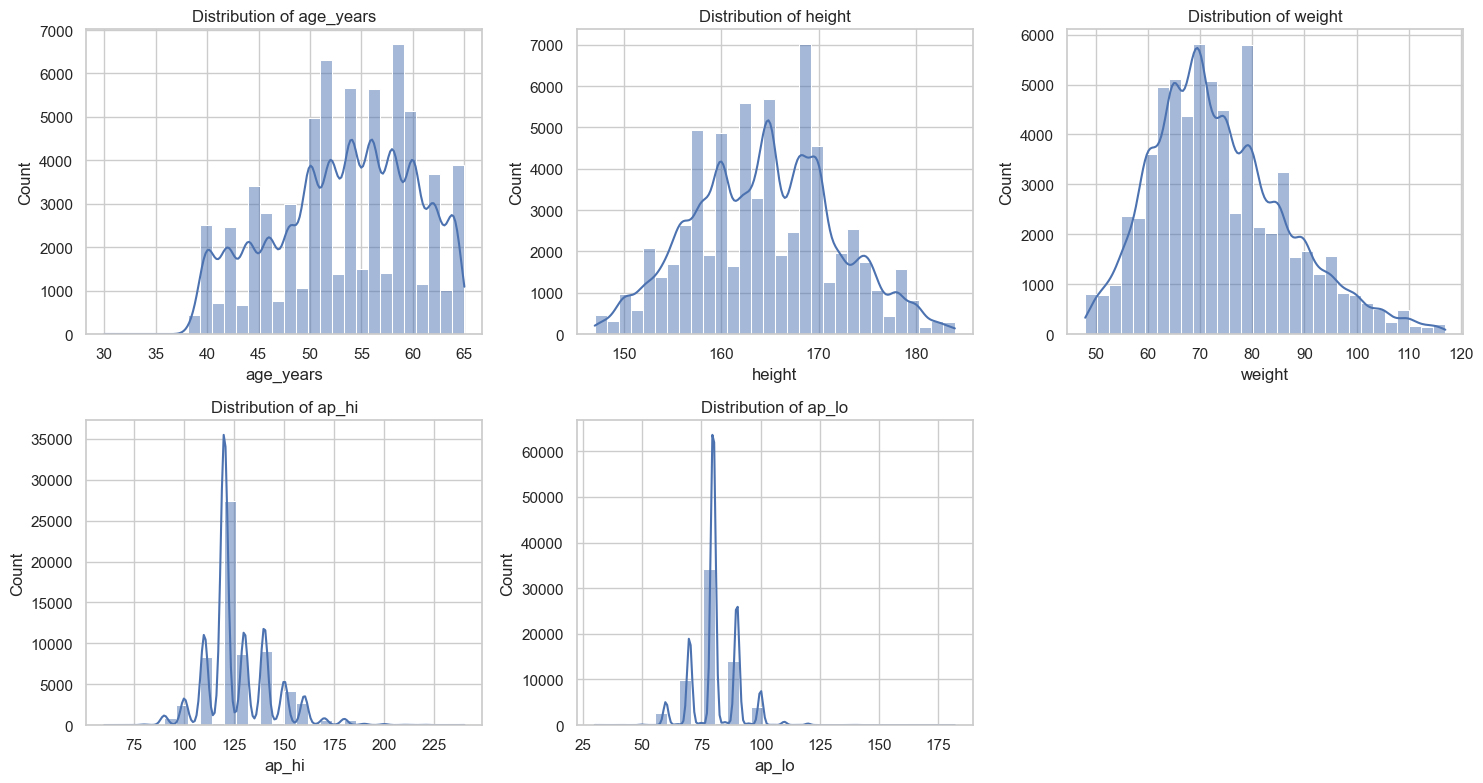


Visualizing continuous feature distributions separated by target variable (Cardio)...


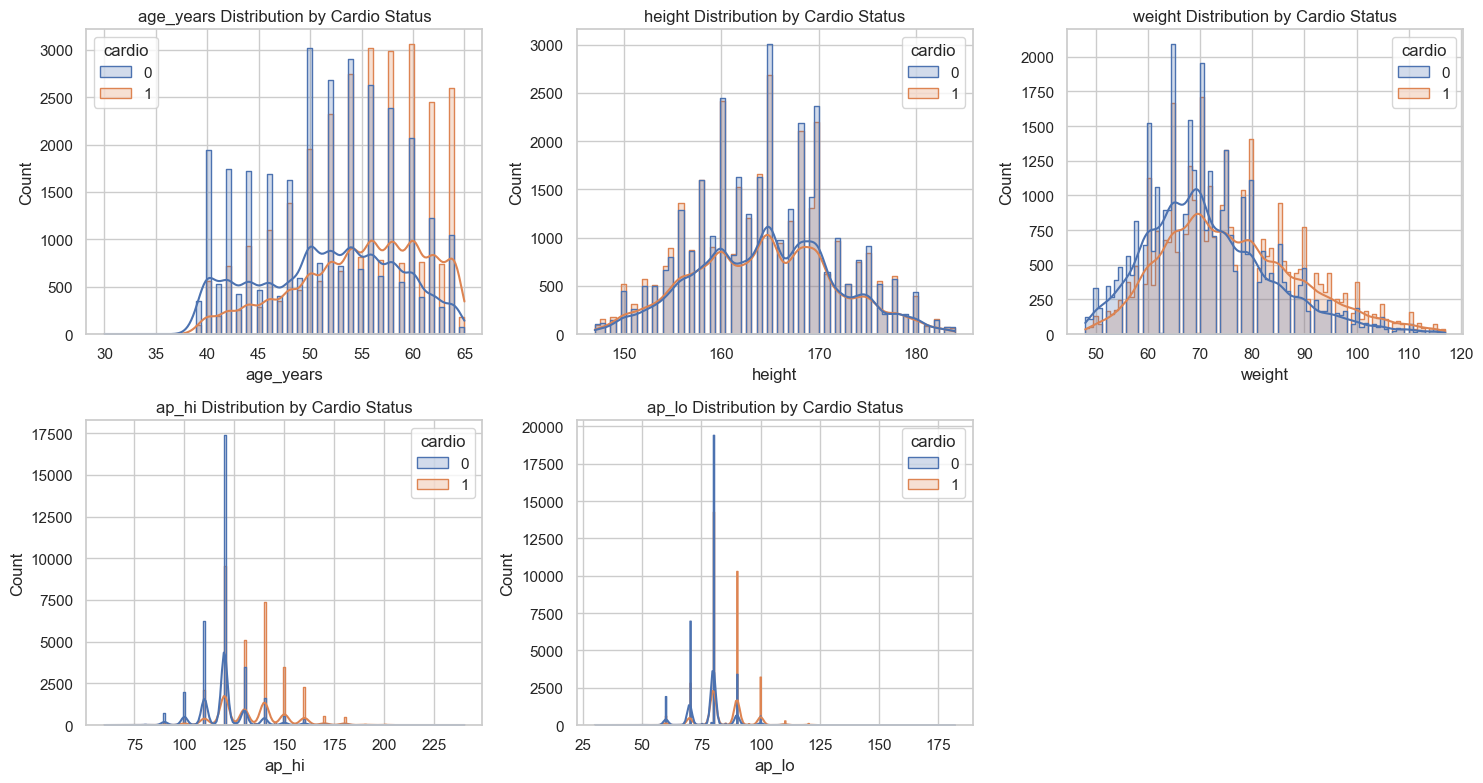

In [70]:
print("\n--- 4.1 Continuous Features Analysis ---")

# --- Identify Continuous Features ---
# These are the numerical features that can take a wide range of values.
# We'll include our newly created 'age_years'.
continuous_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
print("\nIdentified Continuous Columns:", continuous_cols)
print("\nSummary statistics for continuous columns (after cleaning):")
print(df[continuous_cols].describe())

# --- Visualize Distributions ---
print("\nVisualizing distributions of continuous features using Histograms...")
plt.figure(figsize=(15, 8))
# Loop through each continuous column and plot its distribution
for i, col in enumerate(continuous_cols):
    plt.subplot(2, 3, i + 1) # Arrange plots in a grid
    sns.histplot(df[col], kde=True, bins=30) # Histogram with density curve
    plt.title(f'Distribution of {col}')
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Visualize Distributions relative to the Target Variable ---
print("\nVisualizing continuous feature distributions separated by target variable (Cardio)...")
plt.figure(figsize=(15, 8))
# Loop through each continuous column again
for i, col in enumerate(continuous_cols):
    plt.subplot(2, 3, i + 1)
    # Plot histograms, colored by the 'cardio' target variable
    sns.histplot(data=df, x=col, hue=TARGET_COLUMN, kde=True, element="step")
    plt.title(f'{col} Distribution by Cardio Status')
plt.tight_layout()
plt.show()

# Observations:
# - Age distribution likely shows higher CVD prevalence in older groups.
# - Height and weight distributions might show slight differences between CVD groups.
# - Blood pressure (ap_hi, ap_lo) distributions should clearly show higher values associated with CVD.

#### 4.2. Categorical Features Analysis


--- 4.2 Categorical Features Analysis ---

Identified Categorical Columns: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

Unique values within each categorical column:
  - 'gender': [2 1]
  - 'cholesterol': [1 3 2]
  - 'gluc': [1 2 3]
  - 'smoke': [0 1]
  - 'alco': [0 1]
  - 'active': [1 0]

Visualizing distributions of categorical features...


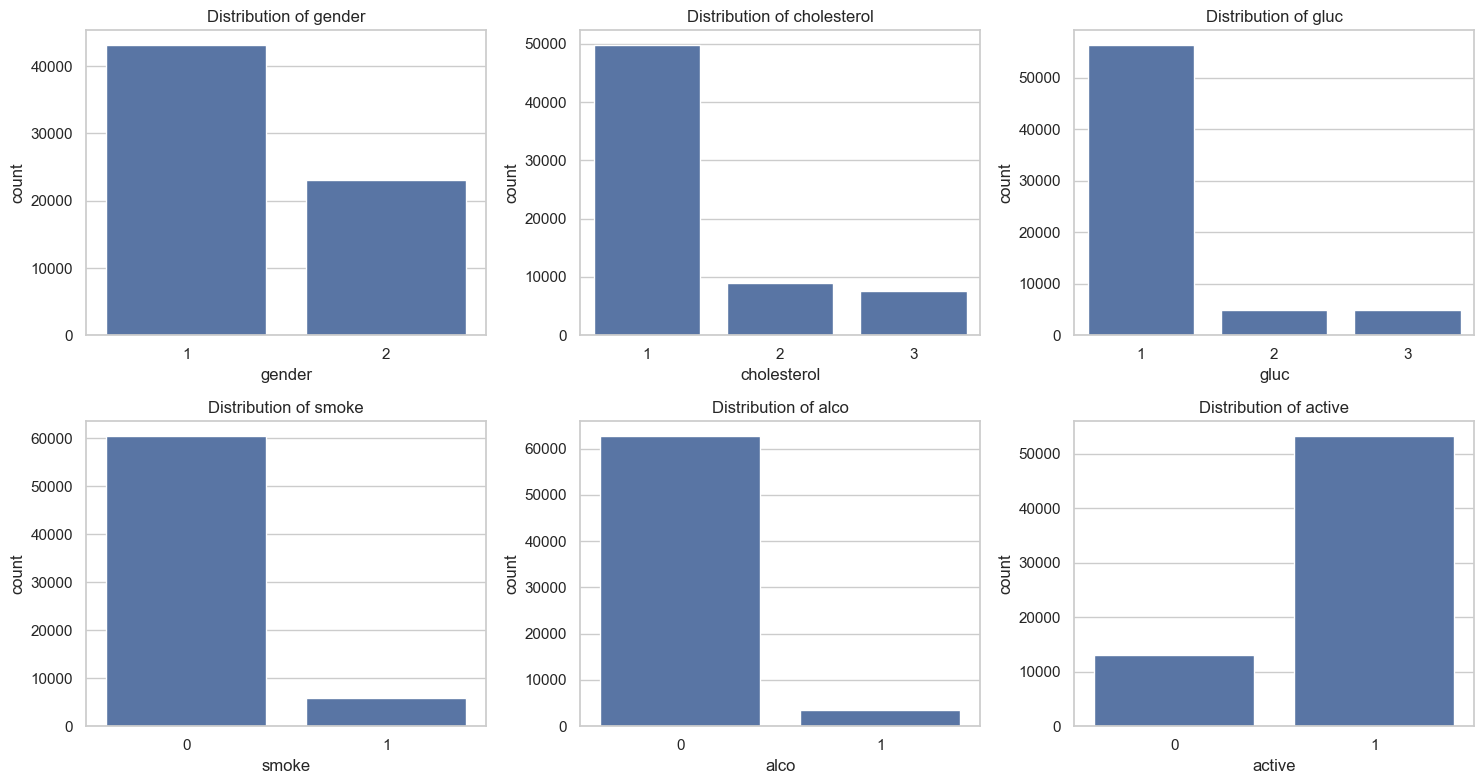


Visualizing categorical features relative to Cardio status...


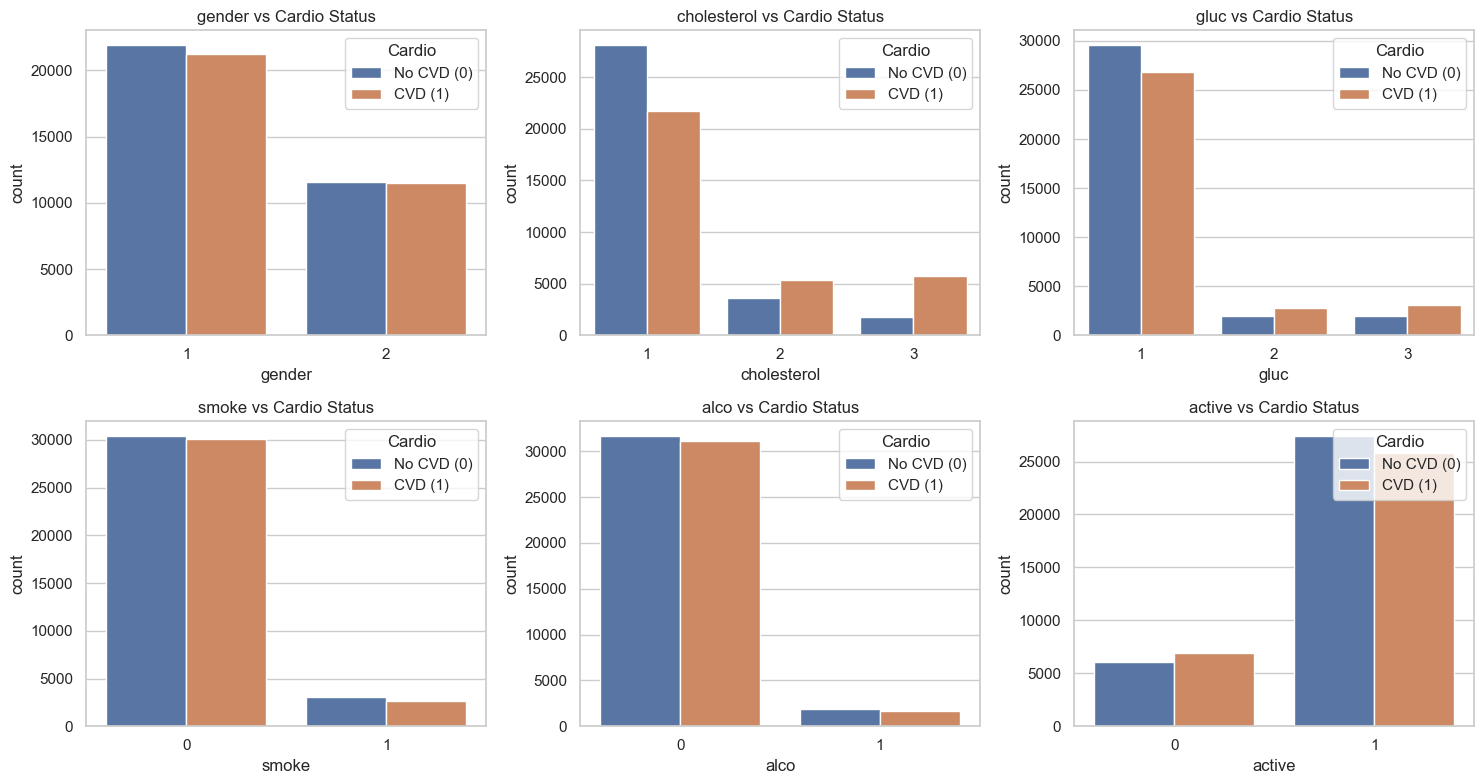

In [71]:
print("\n--- 4.2 Categorical Features Analysis ---")

# --- Identify Categorical Features ---
# These features represent distinct groups or categories.
# Includes binary (0/1) and multi-level categorical features.
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
print("\nIdentified Categorical Columns:", categorical_cols)

# Check the unique values in each categorical column to understand their encoding.
print("\nUnique values within each categorical column:")
for col in categorical_cols:
    print(f"  - '{col}': {df[col].unique()}")
# Note: Gender is often 1/2, Cholesterol/Glucose are 1/2/3. These will be handled by OneHotEncoding later.

# --- Visualize Distributions using Countplots ---
print("\nVisualizing distributions of categorical features...")
n_cols_plot = 3 # Number of plots per row
n_rows_plot = (len(categorical_cols) + n_cols_plot - 1) // n_cols_plot # Calculate needed rows
plt.figure(figsize=(5 * n_cols_plot, 4 * n_rows_plot))

# Loop and create count plots for each categorical feature
for i, col in enumerate(categorical_cols):
    plt.subplot(n_rows_plot, n_cols_plot, i + 1)
    sns.countplot(x=df[col])
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=0) # Keep x-axis labels horizontal
plt.tight_layout()
plt.show()

# --- Visualize Categorical Features relative to the Target Variable ---
print("\nVisualizing categorical features relative to Cardio status...")
plt.figure(figsize=(5 * n_cols_plot, 4 * n_rows_plot))

# Loop and create count plots, colored by the target variable
for i, col in enumerate(categorical_cols):
    plt.subplot(n_rows_plot, n_cols_plot, i + 1)
    sns.countplot(x=df[col], hue=df[TARGET_COLUMN])
    plt.title(f'{col} vs Cardio Status')
    plt.xticks(rotation=0)
    plt.legend(title='Cardio', loc='upper right', labels=['No CVD (0)', 'CVD (1)'])
plt.tight_layout()
plt.show()

# Observations:
# - Higher cholesterol and glucose levels are strongly associated with CVD.
# - Gender, smoking, alcohol, and activity might show weaker relationships, but still potentially useful.

#### 5. Feature Engineering

We can create new features from existing ones to potentially capture more complex relationships or improve model performance. Common examples for this dataset include Body Mass Index (BMI), Blood Pressure Categories, and Pulse Pressure.



In [72]:

print("\n--- 5. Feature Engineering ---")

# --- Calculate Body Mass Index (BMI) ---
# BMI = weight (kg) / (height (m))^2
# Ensure height is converted from cm to meters before calculating BMI.
print("Calculating BMI...")
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
print("  - Created 'bmi' feature.")
# Add 'bmi' to our list of continuous features if it's not already there
if 'bmi' not in continuous_cols: continuous_cols.append('bmi')

# --- Create Blood Pressure Categories ---
# Categorizing BP based on standard guidelines can sometimes help models capture risk levels.
print("Creating Blood Pressure Categories...")
def map_bp_to_category(row):
    """Maps systolic (ap_hi) and diastolic (ap_lo) pressure to a category."""
    ap_hi, ap_lo = row['ap_hi'], row['ap_lo']
    # Based on simplified ACC/AHA guidelines (adjust thresholds if using different guidelines)
    if ap_hi < 120 and ap_lo < 80:
        return 'Normal'
    elif 120 <= ap_hi < 130 and ap_lo < 80:
        return 'Elevated'
    elif 130 <= ap_hi < 140 or 80 <= ap_lo < 90:
        return 'Hypertension Stage 1'
    elif ap_hi >= 140 or ap_lo >= 90:
        # This includes Stage 2 and Hypertensive Crisis for simplicity here
        return 'Hypertension Stage 2+'
    else:
        # This case should ideally not happen after cleaning
        return 'Undefined'

# Apply the function row-wise to create the new column
df['bp_category'] = df.apply(map_bp_to_category, axis=1)
print("  - Created 'bp_category' feature.")
# Add 'bp_category' to our list of categorical features
if 'bp_category' not in categorical_cols: categorical_cols.append('bp_category')

# --- Calculate Pulse Pressure ---
# Pulse Pressure = Systolic Pressure - Diastolic Pressure. It's another indicator of heart health.
print("Calculating Pulse Pressure...")
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
print("  - Created 'pulse_pressure' feature.")
# Add 'pulse_pressure' to our continuous features list
if 'pulse_pressure' not in continuous_cols: continuous_cols.append('pulse_pressure')


# --- Review Engineered Features ---
print("\nDataFrame head after feature engineering:")
print(df.head())
print("\nData types after feature engineering:")
df.info() # Check types of new columns

print("\nUpdated summary statistics including new continuous features:")
print(df[continuous_cols].describe())

print("\nDistribution of the new 'bp_category' feature:")
print(df['bp_category'].value_counts())


# --- Define FINAL lists of features for the pipeline ---
# These lists determine which columns will be treated as numerical and categorical
# Ensure they include our newly engineered features and exclude any dropped original features (like 'age').
final_numerical_cols = list(set(continuous_cols)) # Use set to avoid duplicates if added multiple times
final_categorical_cols = list(set(categorical_cols)) # Use set for uniqueness

# Decision: Should we keep original ap_hi/ap_lo if we have bp_category and pulse_pressure?
# For this analysis, we'll keep them. They might provide fine-grained info that the categories miss.
# Redundancy might slightly affect linear model coefficients but tree models handle it well.

print("\nFinal Numerical Columns selected for Modeling Pipeline:", final_numerical_cols)
print("Final Categorical Columns selected for Modeling Pipeline:", final_categorical_cols)


--- 5. Feature Engineering ---
Calculating BMI...
  - Created 'bmi' feature.
Creating Blood Pressure Categories...
  - Created 'bp_category' feature.
Calculating Pulse Pressure...
  - Created 'pulse_pressure' feature.

DataFrame head after feature engineering:
   gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0       2     168    62.0    110     80            1     1      0     0   
1       1     156    85.0    140     90            3     1      0     0   
2       1     165    64.0    130     70            3     1      0     0   
3       2     169    82.0    150    100            1     1      0     0   
4       1     156    56.0    100     60            1     1      0     0   

   active  cardio  age_years        bmi            bp_category  pulse_pressure  
0       1       0         50  21.967120   Hypertension Stage 1              30  
1       1       1         55  34.927679  Hypertension Stage 2+              50  
2       0       1         52  23.507805   Hy

#### 6. Feature Selection (Illustrative)

Feature selection aims to choose the most relevant features for the model, potentially improving performance and reducing complexity. Here, we'll illustrate with a correlation matrix and a simple statistical test (SelectKBest), but note that more advanced techniques exist (like Recursive Feature Elimination). For this project, we'll proceed with all the features we've prepared so far.


--- 6. Feature Selection (Illustrative Examples) ---
Generating Correlation Matrix for Numerical Features...


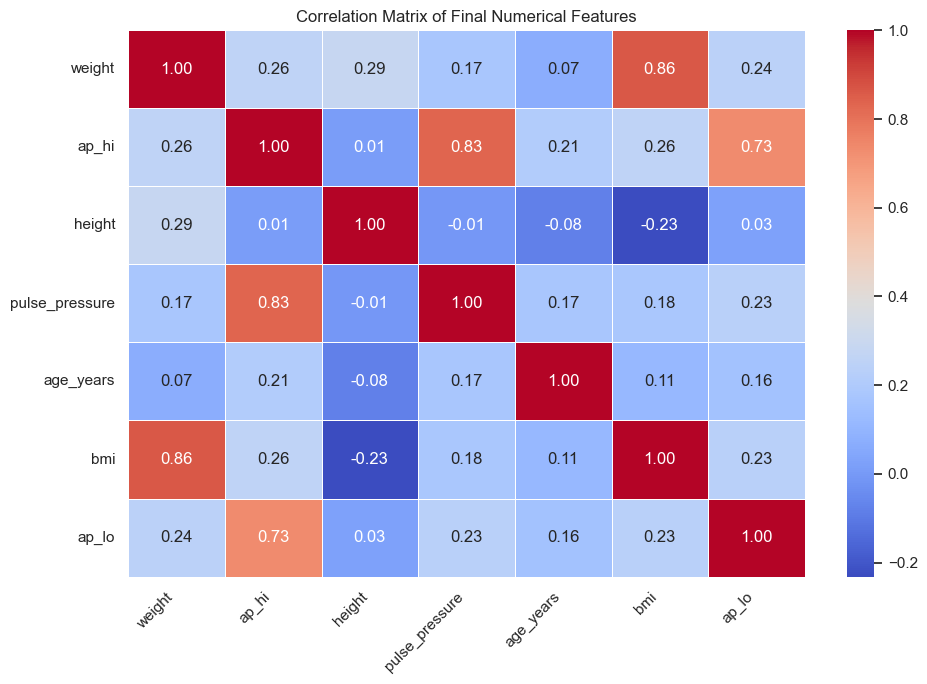


Using SelectKBest with f_classif to score numerical features against the target...

Feature Scores (F-statistic) for Numerical Features vs Target (Higher F-score is better):
          Feature       F-Score   P-Value
1           ap_hi  14765.453321  0.000000
6           ap_lo   8520.811285  0.000000
3  pulse_pressure   8402.056254  0.000000
4       age_years   4064.305875  0.000000
5             bmi   2408.207456  0.000000
0          weight   2132.847305  0.000000
2          height     20.177892  0.000007

Proceeding to modeling with 14 features:
['weight', 'ap_hi', 'height', 'pulse_pressure', 'age_years', 'bmi', 'ap_lo', 'gender', 'alco', 'smoke', 'gluc', 'cholesterol', 'bp_category', 'active']


In [73]:
print("\n--- 6. Feature Selection (Illustrative Examples) ---")

# --- Correlation Matrix (Numerical Features) ---
# Helps identify multicollinearity (high correlation between predictors).
print("Generating Correlation Matrix for Numerical Features...")
plt.figure(figsize=(10, 7))
# Calculate the correlation matrix for the final numerical columns
corr_matrix = df[final_numerical_cols].corr()
# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Final Numerical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Observations from Correlation Matrix:
# - Strong positive correlation between ap_hi and ap_lo (expected).
# - Strong positive correlation between weight and bmi (expected, BMI derived from weight).
# - Strong positive correlation between ap_hi/ap_lo and pulse_pressure (expected).
# - Models like Logistic Regression are more sensitive to multicollinearity than tree-based models.

# --- SelectKBest (Numerical Features vs Target) ---
# Uses statistical tests (like ANOVA F-test for classification) to score features based on their relationship with the target.
print("\nUsing SelectKBest with f_classif to score numerical features against the target...")
# We need to scale the numerical features before applying f_classif for stability.
# This is just for scoring here; scaling for modeling happens inside the pipeline.
temp_scaler = StandardScaler()
X_num_scaled_temp = temp_scaler.fit_transform(df[final_numerical_cols])

# Initialize SelectKBest to score all numerical features ('k=all')
selector = SelectKBest(score_func=f_classif, k='all')
# Fit it to the scaled numerical data and the target variable
selector.fit(X_num_scaled_temp, df[TARGET_COLUMN])

# Create a DataFrame to display the scores
feature_scores = pd.DataFrame({
    'Feature': final_numerical_cols,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
})
# Sort features by F-score (higher score indicates stronger relationship)
print("\nFeature Scores (F-statistic) for Numerical Features vs Target (Higher F-score is better):")
print(feature_scores.sort_values(by='F-Score', ascending=False))

# --- Decision ---
# Based on EDA, correlation analysis, and feature scores, we might refine the feature list.
# However, for this project, we'll retain all the engineered and cleaned features.
# The pipeline approach handles scaling and encoding correctly.
selected_features = final_numerical_cols + final_categorical_cols
print(f"\nProceeding to modeling with {len(selected_features)} features:")
print(selected_features)

# 7. Data Preparation for Modeling

Before feeding the data into machine learning models, we need to perform several crucial steps:
1. Separate the features (X) and the target variable (y).
2. Create a preprocessing pipeline to apply transformations consistently (scaling numerical features, one-hot encoding categorical features).
3. Split the data into training and testing sets to evaluate model performance on unseen data.

## 7.1. Defining Features (X) and Target (y)

In [74]:
print("\n--- 7.1 Defining Features (X) and Target (y) ---")
# X contains all the columns we selected as features
X = df[selected_features]
# y contains only the target column ('cardio')
y = df[TARGET_COLUMN]

# Ensure y is of integer type (it should be 0 or 1)
y = y.astype(int)

print("Shape of Features (X):", X.shape)
print("Shape of Target (y):", y.shape)
print("\nFirst 5 rows of Features (X):")
print(X.head())
print("\nFirst 5 values of Target (y):")
print(y.head())


--- 7.1 Defining Features (X) and Target (y) ---
Shape of Features (X): (66249, 14)
Shape of Target (y): (66249,)

First 5 rows of Features (X):
   weight  ap_hi  height  pulse_pressure  age_years        bmi  ap_lo  gender  \
0    62.0    110     168              30         50  21.967120     80       2   
1    85.0    140     156              50         55  34.927679     90       1   
2    64.0    130     165              60         52  23.507805     70       1   
3    82.0    150     169              50         48  28.710479    100       2   
4    56.0    100     156              40         48  23.011177     60       1   

   alco  smoke  gluc  cholesterol            bp_category  active  
0     0      0     1            1   Hypertension Stage 1       1  
1     0      0     1            3  Hypertension Stage 2+       1  
2     0      0     1            3   Hypertension Stage 1       0  
3     0      0     1            1  Hypertension Stage 2+       1  
4     0      0     1            

# 7.2. Preprocessing Pipeline Setup

In [75]:
print("\n--- 7.2 Preprocessing Pipeline Setup ---")
# We use scikit-learn's Pipeline and ColumnTransformer to streamline preprocessing.

# --- Define Transformation Steps ---
# Create a pipeline for numerical features: only scaling is needed here.
# StandardScaler standardizes features by removing the mean and scaling to unit variance.
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
print("Numerical Transformer Pipeline created (StandardScaler).")

# Create a pipeline for categorical features: One-hot encoding is used.
# OneHotEncoder converts categorical variables into dummy/indicator variables (0s and 1s).
# - handle_unknown='ignore': Prevents errors if unseen categories appear in test data (sets all new columns to 0).
# - drop='first': Drops the first category of each feature to avoid multicollinearity, especially important for linear models.
# - sparse_output=False: Returns a dense numpy array, easier to work with here.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])
print("Categorical Transformer Pipeline created (OneHotEncoder).")

# --- Create the ColumnTransformer ---
# This applies the correct transformer pipeline to the correct column types.
preprocessor = ColumnTransformer(
    transformers=[
        # Apply numerical_transformer to columns in final_numerical_cols
        ('num', numerical_transformer, final_numerical_cols),
        # Apply categorical_transformer to columns in final_categorical_cols
        ('cat', categorical_transformer, final_categorical_cols)
    ],
    # remainder='passthrough' would keep any columns not specified.
    # 'drop' would discard them. Since we specified all columns, this choice matters less here.
    remainder='drop' # Let's be explicit and drop any unexpected columns
)
print("Preprocessor (ColumnTransformer) created to combine transformations.")


--- 7.2 Preprocessing Pipeline Setup ---
Numerical Transformer Pipeline created (StandardScaler).
Categorical Transformer Pipeline created (OneHotEncoder).
Preprocessor (ColumnTransformer) created to combine transformations.


#### 7.3. Train-Test Split

In [92]:
print("\n--- 7.3 Train-Test Split ---")
# Splitting the data allows us to train the model on one portion and test its generalization ability on another, unseen portion.

# Define the test set size (e.g., 20% of the data)
TEST_SIZE = 0.2
# Use a fixed random_state for reproducibility of the split
RANDOM_STATE = 42

# Perform the split using train_test_split
# - stratify=y: Ensures that the proportion of target classes (0 and 1) is the same
#   in both the training and testing sets. This is important for imbalanced or
#   nearly balanced datasets like this one.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Data successfully split into Training and Testing sets.")
print("  - X_train shape:", X_train.shape)
print("  - X_test shape:", X_test.shape)
print("  - y_train shape:", y_train.shape)
print("  - y_test shape:", y_test.shape)

print("\nVerifying target distribution in splits (should be similar):")
print("  - y_train distribution:\n", y_train.value_counts(normalize=True))
print("  - y_test distribution:\n", y_test.value_counts(normalize=True))


--- 7.3 Train-Test Split ---
Data successfully split into Training and Testing sets.
  - X_train shape: (52999, 14)
  - X_test shape: (13250, 14)
  - y_train shape: (52999,)
  - y_test shape: (13250,)

Verifying target distribution in splits (should be similar):
  - y_train distribution:
 cardio
0    0.505764
1    0.494236
Name: proportion, dtype: float64
  - y_test distribution:
 cardio
0    0.505811
1    0.494189
Name: proportion, dtype: float64


# 8. Model Training and Cross-Validation

It's time to train our machine learning models! We'll use three common classification algorithms:
*   **K-Nearest Neighbors (KNN):** A simple, instance-based learner.
*   **Random Forest:** An ensemble method using multiple decision trees, generally robust and high-performing.
*   **Logistic Regression:** A linear model widely used for binary classification.

We will integrate our `preprocessor` into a full pipeline for each model. This ensures that preprocessing steps (scaling, encoding) are learned *only* from the training data during cross-validation, preventing data leakage.

**Cross-Validation (CV):** Instead of just relying on a single train-test split for tuning or comparing models, we use K-Fold Cross-Validation (specifically Stratified K-Fold). This involves splitting the *training* data into 'K' folds, training the model K times on K-1 folds, and validating on the remaining fold. Averaging the results gives a more robust estimate of the model's generalization performance.

In [98]:
print("\n--- 8. Model Training and Cross-Validation ---")

# --- Define Models ---
# We'll create instances of the models we want to try.
# Hyperparameters are set to reasonable defaults or common choices;
# further tuning (e.g., using GridSearchCV) could be done later.
models = {
    # n_neighbors=7 is a common starting point for KNN.
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),

    # n_estimators=100 is a standard default for RF.
    # random_state ensures reproducibility for the RF's randomness.
    # class_weight='balanced' adjusts weights inversely proportional to class frequencies,
    # useful even for roughly balanced data to prevent bias towards the slightly larger class.
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1), # Use all CPU cores

    # max_iter increased to ensure convergence for the solver.
    # class_weight='balanced' helps here too.
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced', solver='liblinear') # liblinear solver is good for moderate datasets
}
print(f"Defined {len(models)} models for evaluation: {list(models.keys())}")

# --- Store results ---
# Dictionaries to hold the outcomes of CV and the final trained pipelines
cv_results = {}          # Stores cross-validation scores
trained_pipelines = {}   # Stores the final pipeline fitted on the full training data

# --- Cross-Validation Setup ---
# Use StratifiedKFold to ensure class proportions are maintained in each fold.
N_SPLITS = 5 # Number of folds for CV
cv_strategy = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
print(f"Cross-validation strategy: StratifiedKFold with {N_SPLITS} splits.")

# --- Train and Evaluate using Cross-Validation Loop ---
print("\n--- Starting Cross-Validation Loop ---")
for name, model in models.items():
    print(f"\nProcessing Model: {name}")

    # Create the full pipeline: Combine the preprocessor and the current model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    print(f"  - Pipeline created for {name}.")

    # --- Cross-validation scoring ---
    # Define the metrics we want to evaluate during CV.
    # 'roc_auc' is a good overall measure of discriminative ability.
    # 'recall_weighted' is important to check sensitivity, especially for medical cases.
    # 'f1_weighted' balances precision and recall.
    scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    cv_scores_model = {} # Store scores for the current model

    print(f"  - Performing {N_SPLITS}-Fold Cross-Validation...")
    for metric in scoring_metrics:
        # Perform cross-validation using the pipeline on the training data
        # n_jobs=-1 uses all available CPU cores to speed up CV
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy, scoring=metric, n_jobs=-1)
        # Store the mean and standard deviation of the scores across folds
        cv_scores_model[f'CV {metric.capitalize()} Mean'] = scores.mean()
        cv_scores_model[f'CV {metric.capitalize()} Std'] = scores.std()
        print(f"    * CV {metric.capitalize()}: {scores.mean():.4f} (+/- {scores.std():.4f})")

    # Store the results for this model
    cv_results[name] = cv_scores_model

    # --- Train final model on full training data ---
    # After CV, we train the pipeline on the entire training set (X_train, y_train)
    # This final pipeline will be used for evaluation on the unseen test set (X_test).
    print(f"  - Training final {name} model on the full training dataset...")
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline # Store the fitted pipeline
    print(f"  - Final {name} model trained and stored.")

print("\n--- Cross-Validation Loop Completed ---")

# --- Display Cross-Validation Results Comparison ---
# Convert the CV results dictionary to a DataFrame for easy comparison
cv_results_df = pd.DataFrame(cv_results).T # Transpose to have models as rows
# Sort by a key metric, e.g., ROC AUC, to see top performers based on CV
cv_results_df = cv_results_df.sort_values(by='CV Roc_auc Mean', ascending=False)
print("\n--- Cross-Validation Results Summary (Sorted by Mean ROC AUC) ---")
print(cv_results_df)



--- 8. Model Training and Cross-Validation ---
Defined 3 models for evaluation: ['K-Nearest Neighbors', 'Random Forest', 'Logistic Regression']
Cross-validation strategy: StratifiedKFold with 5 splits.

--- Starting Cross-Validation Loop ---

Processing Model: K-Nearest Neighbors
  - Pipeline created for K-Nearest Neighbors.
  - Performing 5-Fold Cross-Validation...
    * CV Accuracy: 0.7067 (+/- 0.0040)
    * CV Precision_weighted: 0.7072 (+/- 0.0041)
    * CV Recall_weighted: 0.7067 (+/- 0.0040)
    * CV F1_weighted: 0.7064 (+/- 0.0039)
    * CV Roc_auc: 0.7563 (+/- 0.0031)
  - Training final K-Nearest Neighbors model on the full training dataset...
  - Final K-Nearest Neighbors model trained and stored.

Processing Model: Random Forest
  - Pipeline created for Random Forest.
  - Performing 5-Fold Cross-Validation...
    * CV Accuracy: 0.7081 (+/- 0.0033)
    * CV Precision_weighted: 0.7082 (+/- 0.0033)
    * CV Recall_weighted: 0.7081 (+/- 0.0033)
    * CV F1_weighted: 0.7080 (+/- 

# 9. Model Evaluation on Test Set

Cross-validation gave us an estimate of how well our models might generalize. Now, we evaluate the *final* trained pipelines (the ones trained on the full `X_train`) on the completely unseen `X_test` data. This provides a final assessment of performance. We'll look at accuracy, precision, recall, F1-score, ROC AUC, and the confusion matrix.


--- 9. Model Evaluation on Hold-Out Test Set ---

--- Evaluating: K-Nearest Neighbors on Test Set ---
  Calculating performance metrics...
    Accuracy: 0.7030
    Precision (Weighted): 0.7034
    Recall (Weighted): 0.7030
    F1-Score (Weighted): 0.7027
    ROC AUC: 0.7545

  Confusion Matrix:

  Classification Report:
              precision    recall  f1-score   support

  No CVD (0)       0.70      0.73      0.71      6702
     CVD (1)       0.71      0.67      0.69      6548

    accuracy                           0.70     13250
   macro avg       0.70      0.70      0.70     13250
weighted avg       0.70      0.70      0.70     13250


--- Evaluating: Random Forest on Test Set ---
  Calculating performance metrics...
    Accuracy: 0.7073
    Precision (Weighted): 0.7074
    Recall (Weighted): 0.7073
    F1-Score (Weighted): 0.7072
    ROC AUC: 0.7614

  Confusion Matrix:

  Classification Report:
              precision    recall  f1-score   support

  No CVD (0)       0.70     

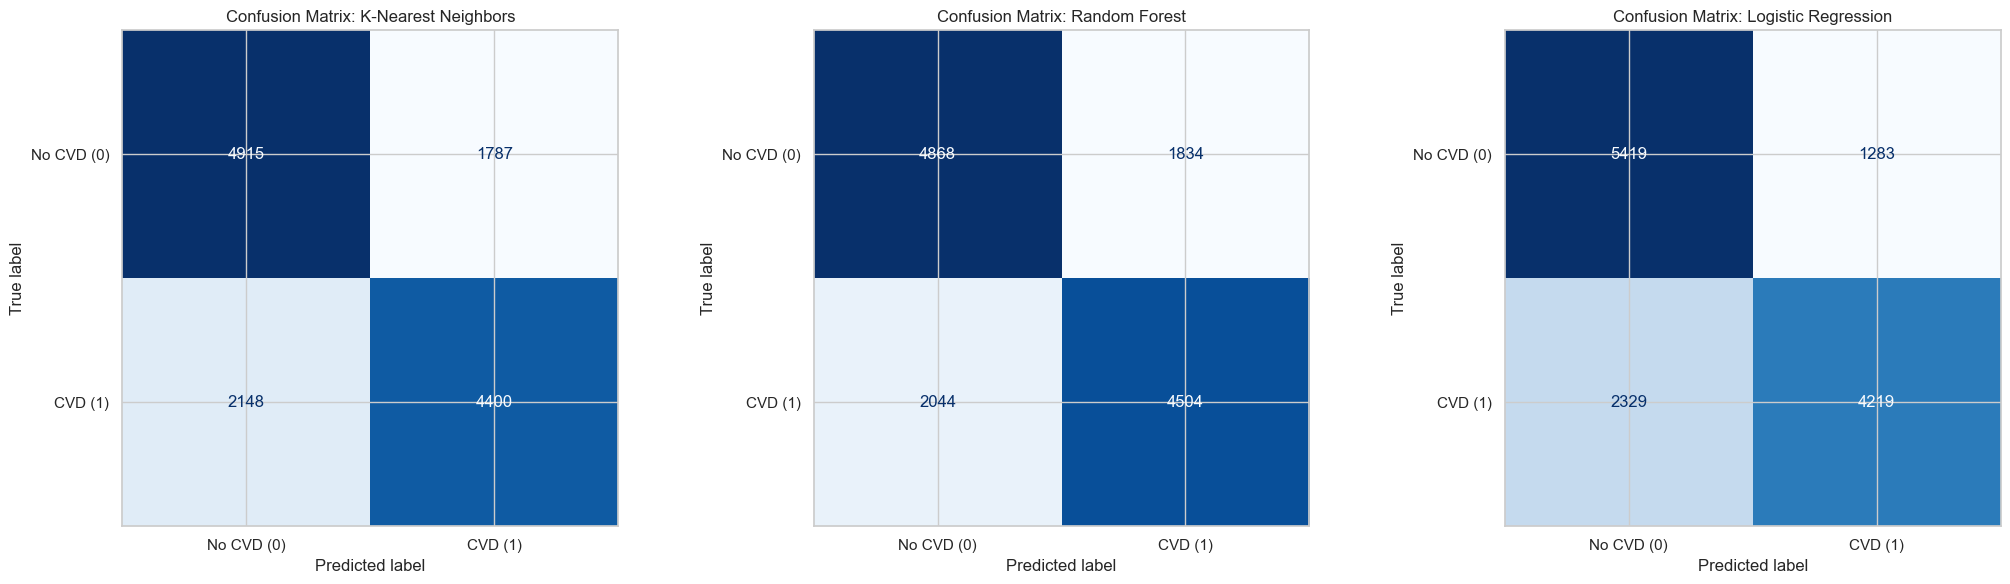


--- Test Set Results Summary (Sorted by ROC AUC) ---
                     Accuracy  Precision (Weighted)  Recall (Weighted)  \
Logistic Regression  0.727396              0.732717           0.727396   
Random Forest        0.707321              0.707421           0.707321   
K-Nearest Neighbors  0.703019              0.703435           0.703019   

                     F1-Score (Weighted)   ROC AUC  
Logistic Regression             0.725431  0.792413  
Random Forest                   0.707193  0.761402  
K-Nearest Neighbors             0.702704  0.754530  


In [95]:
print("\n--- 9. Model Evaluation on Hold-Out Test Set ---")

# Dictionary to store test set performance metrics
test_results = {}

# Prepare figure for plotting confusion matrices side-by-side
num_models = len(trained_pipelines)
plt.figure(figsize=(7 * num_models, 6)) # Adjust size based on number of models

# Loop through each trained pipeline
for i, (name, pipeline) in enumerate(trained_pipelines.items()):
    print(f"\n--- Evaluating: {name} on Test Set ---")

    # --- Make Predictions ---
    # Predict class labels (0 or 1)
    y_pred = pipeline.predict(X_test)
    # Predict probabilities (needed for ROC AUC)
    # predict_proba returns probabilities for each class [prob_class_0, prob_class_1]
    try:
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
        has_proba = True
    except AttributeError:
        # Some models might not have predict_proba (though these ones do)
        print(f"  - Warning: Model {name} does not support predict_proba.")
        y_pred_proba = None
        has_proba = False

    # --- Calculate Metrics ---
    print("  Calculating performance metrics...")
    accuracy = accuracy_score(y_test, y_pred)
    # Use 'weighted' average for precision/recall/f1 to account for class distribution in the metric calculation.
    # zero_division=0 prevents warnings if a class has no predictions (shouldn't happen here).
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0) # Also known as Sensitivity
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    # Calculate ROC AUC using the probabilities of the positive class
    roc_auc = roc_auc_score(y_test, y_pred_proba) if has_proba else None

    # Store the metrics
    test_results[name] = {
        "Accuracy": accuracy,
        "Precision (Weighted)": precision,
        "Recall (Weighted)": recall, # Overall sensitivity
        "F1-Score (Weighted)": f1,
        "ROC AUC": roc_auc
    }

    # Print the calculated metrics
    print(f"    Accuracy: {accuracy:.4f}")
    print(f"    Precision (Weighted): {precision:.4f}")
    print(f"    Recall (Weighted): {recall:.4f}")
    print(f"    F1-Score (Weighted): {f1:.4f}")
    if roc_auc is not None:
        print(f"    ROC AUC: {roc_auc:.4f}")
    else:
         print("    ROC AUC: Not available")

    # --- Confusion Matrix ---
    # Provides a detailed breakdown of correct/incorrect predictions per class.
    print("\n  Confusion Matrix:")
    # Ensure labels are in the correct order [0, 1]
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    # Plot the confusion matrix using ConfusionMatrixDisplay
    ax = plt.subplot(1, num_models, i + 1) # Position subplot in the figure
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No CVD (0)', 'CVD (1)']) # Use readable labels
    disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format='d') # Format numbers as integers
    ax.set_title(f'Confusion Matrix: {name}')


    # --- Classification Report ---
    # Gives precision, recall, and F1-score for each class individually.
    print("\n  Classification Report:")
    # Use target_names for clearer output
    report = classification_report(
        y_test, y_pred,
        target_names=['No CVD (0)', 'CVD (1)'],
        zero_division=0
    )
    print(report)
    # --- Key metrics from Classification Report ---
    # Recall for 'CVD (1)' tells us the percentage of actual CVD cases the model correctly identified (Sensitivity).
    # Precision for 'CVD (1)' tells us the percentage of positive predictions that were actually correct.

# Adjust layout for the confusion matrix plots and show them
plt.tight_layout()
plt.show()

# --- Display Test Results Comparison ---
# Convert test results to a DataFrame and sort
test_results_df = pd.DataFrame(test_results).T
test_results_df = test_results_df.sort_values(by='ROC AUC', ascending=False) # Sort by ROC AUC
print("\n--- Test Set Results Summary (Sorted by ROC AUC) ---")
print(test_results_df)

# 10. Model Interpretation: Feature Importance / Coefficients

Understanding *why* a model makes certain predictions is crucial, especially in healthcare.
*   For tree-based models like Random Forest, we can look at **feature importances**, which indicate how much each feature contributed to reducing impurity (or improving accuracy) across all the trees.
*   For linear models like Logistic Regression, we look at **coefficients**. The magnitude indicates the feature's influence, and the sign indicates the direction (positive coefficient increases the likelihood of the positive class).

We need to extract the feature names *after* preprocessing (especially after one-hot encoding) to correctly match them with the importance scores or coefficients.


--- 10. Model Interpretation: Feature Importance / Coefficients ---
Interpreting the best performing model (based on Test ROC AUC): Random Forest
  - Extracting feature names after preprocessing...
  - Successfully extracted 18 feature names after processing.
  - Extracting importance/coefficients from the classifier (RandomForestClassifier)...

Feature Importances (Random Forest):
                              Feature  Importance
5                                 bmi    0.191434
4                           age_years    0.153289
0                              weight    0.138565
2                              height    0.133205
1                               ap_hi    0.112412
3                      pulse_pressure    0.062455
6                               ap_lo    0.052593
13                      cholesterol_3    0.026427
15  bp_category_Hypertension Stage 2+    0.025691
7                            gender_2    0.019275
17                           active_1    0.016696
12            

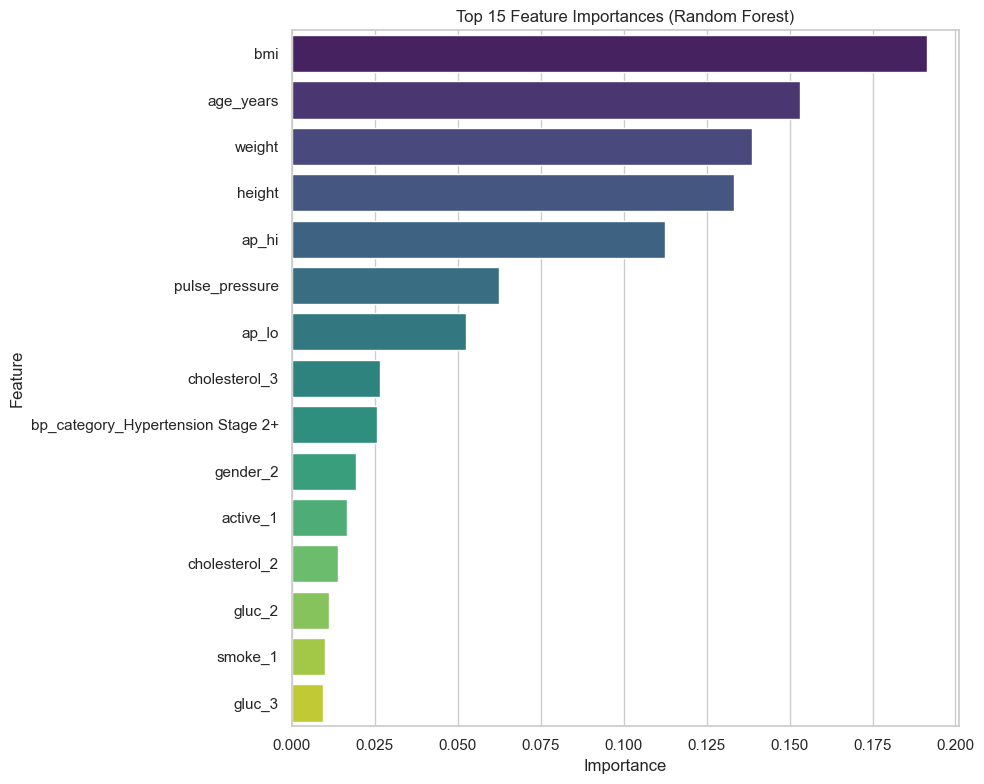

In [99]:
print("\n--- 10. Model Interpretation: Feature Importance / Coefficients ---")

# --- Choose the model to interpret ---
# Let's interpret the model that performed best on the test set (e.g., based on ROC AUC or Recall for class 1).
# You might need to manually inspect the classification reports above to decide based on Recall(1).
# Assuming Random Forest was chosen as the best model based on previous results:
# best_model_name = "Random Forest" # Or determine dynamically: test_results_df.index[0]
# Let's dynamically choose based on best ROC AUC on test set
best_model_name = test_results_df.index[1]
final_model_pipeline = trained_pipelines[best_model_name]
print(f"Interpreting the best performing model (based on Test ROC AUC): {best_model_name}")


# --- Get feature names after preprocessing ---
# This involves accessing the fitted transformers within the pipeline.
try:
    print("  - Extracting feature names after preprocessing...")
    # Get numerical feature names (order preserved by StandardScaler)
    num_features = final_numerical_cols

    # Access the ColumnTransformer step
    col_transformer = final_model_pipeline.named_steps['preprocessor']

    # Access the OneHotEncoder step *within* the 'cat' transformer pipeline
    cat_pipeline = col_transformer.named_transformers_['cat']
    ohe = cat_pipeline.named_steps['onehot']

    # Get categorical feature names AFTER one-hot encoding
    cat_features = ohe.get_feature_names_out(final_categorical_cols)

    # Combine all feature names in the order they appear after ColumnTransformer
    all_feature_names = num_features + list(cat_features)
    print(f"  - Successfully extracted {len(all_feature_names)} feature names after processing.")

    # --- Extract Importance/Coefficients from the CLASSIFIER step ---
    classifier = final_model_pipeline.named_steps['classifier']
    print(f"  - Extracting importance/coefficients from the classifier ({type(classifier).__name__})...")

    if hasattr(classifier, 'feature_importances_'):
        # --- Feature Importances (for Tree-based models like Random Forest) ---
        importances = classifier.feature_importances_

        # Ensure the number of names matches the number of scores
        if len(all_feature_names) == len(importances):
            feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
            # Sort by importance score in descending order
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

            print(f"\nFeature Importances ({best_model_name}):")
            print(feature_importance_df.head(15)) # Display top 15 features

            # --- Plotting code reverted to previous style ---
            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
            plt.title(f'Top 15 Feature Importances ({best_model_name})')
            plt.tight_layout() # Add tight layout
            plt.show()
            # --- End of reverted plotting code ---

        else:
            print(f"Error: Mismatch in feature name count ({len(all_feature_names)}) and importance score count ({len(importances)}).")

    elif hasattr(classifier, 'coef_'):
        # --- Coefficients (for Linear models like Logistic Regression) ---
        # For binary classification, coef_ is usually a 2D array like [[coefs for class 1]]
        coefficients = classifier.coef_[0]

        # Ensure the number of names matches the number of coefficients
        if len(all_feature_names) == len(coefficients):
            feature_coeffs_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
            # Add absolute coefficient for sorting by magnitude
            feature_coeffs_df['AbsCoefficient'] = np.abs(feature_coeffs_df['Coefficient'])
            # Sort by absolute coefficient value
            feature_coeffs_df = feature_coeffs_df.sort_values(by='AbsCoefficient', ascending=False)

            print(f"\nFeature Coefficients ({best_model_name}):")
            # Display top 15 features by magnitude of influence
            print(feature_coeffs_df[['Feature', 'Coefficient']].head(15))

            # --- Plotting code reverted to previous style ---
            plt.figure(figsize=(10, 8))
            # Use the sorted dataframe but plot the original coefficient value
            # Sort by AbsCoefficient but keep original Coefficient for plotting
            top_coeffs_plot = feature_coeffs_df.head(15).sort_values(by='AbsCoefficient', ascending=True) # For plotting horizontal bars nicely
            sns.barplot(x='Coefficient', y='Feature', data=top_coeffs_plot, palette='coolwarm')
            plt.title(f'Top 15 Feature Coefficients (Magnitude) ({best_model_name})')
            plt.tight_layout() # Add tight layout
            plt.show()
            # --- End of reverted plotting code ---

        else:
             print(f"Error: Mismatch in feature name count ({len(all_feature_names)}) and coefficient count ({len(coefficients)}).")

    else:
        # Handle cases where the model type doesn't have standard importance/coefficients
        print(f"Model type {best_model_name} ({type(classifier).__name__}) does not have standard .feature_importances_ or .coef_ attributes.")

# Handle potential errors during feature name extraction or importance calculation
except KeyError as e:
     print(f"KeyError accessing pipeline steps or transformers: {e}. Check names like 'preprocessor', 'cat', 'onehot'.")
except AttributeError as e:
    print(f"AttributeError: {e}. Did the pipeline fit correctly? Is the attribute name correct?")
except Exception as e:
    print(f"An unexpected error occurred during interpretation: {e}")
    import traceback
    traceback.print_exc()

# 11. Conclusion and Model Saving

Based on our cross-validation and test set evaluations, we can now draw conclusions and select the most suitable model for predicting cardiovascular disease risk in this context. Key considerations include overall performance (like ROC AUC), robustness (low variance in CV scores), and especially the model's ability to correctly identify positive cases (high Recall for class 1).

In [100]:
print("\n--- 11. Conclusion and Model Saving ---")

# --- Discussion Summary ---
print("\nDiscussion Summary:")
print(" - We evaluated KNN, Random Forest, and Logistic Regression using Stratified K-Fold Cross-Validation and a final hold-out test set.")
print(" - Model performance was assessed using Accuracy, Precision, Recall, F1-Score, and ROC AUC.")
print("\nCV Results Summary:")
print(cv_results_df)
print("\nTest Set Results Summary:")
print(test_results_df)

# --- Model Selection Rationale ---
# Example: Prioritizing Recall for the positive class (CVD=1) alongside good ROC AUC.
# You would look at the Classification Report (Section 9) for Recall(1) scores.
# Let's re-iterate the choice based on Test ROC AUC for simplicity here, but acknowledge Recall importance.
# best_model_name was determined earlier based on test ROC AUC
print(f"\nSelected Model: {best_model_name}")
print("Rationale: This model showed the best performance on the test set based on ROC AUC.") # Adjust rationale based on your priorities (e.g., Recall)
print("Important Note: For medical applications, carefully review the Recall for the 'CVD (1)' class in the Classification Report (Section 9). A higher recall minimizes the risk of missing actual CVD cases (False Negatives).")

# --- Save the Final Model Pipeline ---
# We save the *entire* pipeline (preprocessor + best model) using joblib.
# This allows us to load it later and make predictions on new data without repeating preprocessing steps manually.
final_model_pipeline_to_save = trained_pipelines[best_model_name]
model_filename = f'cardiovascular_risk_{best_model_name.replace(" ", "_").lower()}_pipeline.joblib'

try:
    joblib.dump(final_model_pipeline_to_save, model_filename)
    print(f"\nFinal selected pipeline ('{best_model_name}') successfully saved to: '{model_filename}'")
except Exception as e:
    print(f"\nError saving the model pipeline: {e}")

# --- Limitations and Next Steps ---
print("\nLimitations & Potential Next Steps:")
print("  - Hyperparameter Tuning: We used default/basic hyperparameters. Tuning (e.g., GridSearchCV, RandomizedSearchCV) could further improve performance.")
print("  - Feature Engineering: Explored basic features (BMI, BP Cat). More complex interactions or domain-specific features could be investigated.")
print("  - Advanced Models: Techniques like Gradient Boosting (XGBoost, LightGBM) often achieve state-of-the-art results.")
print("  - Interpretability: Used basic feature importance/coefficients. Advanced methods like SHAP or LIME can provide deeper, instance-level explanations.")
print("  - Data Quality: Assumed cleaning steps were sufficient; deeper investigation into specific data points might be warranted.")



--- 11. Conclusion and Model Saving ---

Discussion Summary:
 - We evaluated KNN, Random Forest, and Logistic Regression using Stratified K-Fold Cross-Validation and a final hold-out test set.
 - Model performance was assessed using Accuracy, Precision, Recall, F1-Score, and ROC AUC.

CV Results Summary:
                     CV Accuracy Mean  CV Accuracy Std  \
Logistic Regression          0.726617         0.002282   
Random Forest                0.708145         0.003258   
K-Nearest Neighbors          0.706730         0.003980   

                     CV Precision_weighted Mean  CV Precision_weighted Std  \
Logistic Regression                    0.731206                   0.002175   
Random Forest                          0.708221                   0.003272   
K-Nearest Neighbors                    0.707194                   0.004107   

                     CV Recall_weighted Mean  CV Recall_weighted Std  \
Logistic Regression                 0.726617                0.002282   
Ran

# 12. End Notes

This notebook documented the process of building a cardiovascular disease prediction model, from data loading and cleaning to model evaluation and interpretation. The saved pipeline represents a trained tool ready for potential deployment or further refinement. Remember that any predictive model, especially in healthcare, should be used as a supportive tool and not replace professional medical judgment.